### What drives price of a car ?

### Business Understanding

### Objectives

### Data

### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [296]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [297]:
# load the provided vehicle dataset 
used_cars = pd.read_csv("data/vehicles.csv")
used_cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


### Exploratory Data Analysis (EDA)

In [298]:
# To make data exploration easie for the first iteration, I am just loading 100,00 random rows into a dataframe
used_cars = used_cars.sample(n=10000)

used_cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 309886 to 232922
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   region        10000 non-null  object 
 2   price         10000 non-null  int64  
 3   year          9975 non-null   float64
 4   manufacturer  9548 non-null   object 
 5   model         9871 non-null   object 
 6   condition     5846 non-null   object 
 7   cylinders     5826 non-null   object 
 8   fuel          9913 non-null   object 
 9   odometer      9866 non-null   float64
 10  title_status  9805 non-null   object 
 11  transmission  9922 non-null   object 
 12  VIN           6210 non-null   object 
 13  drive         7004 non-null   object 
 14  size          2834 non-null   object 
 15  type          7822 non-null   object 
 16  paint_color   6970 non-null   object 
 17  state         10000 non-null  object 
dtypes: float64(2), int64(2), 

In [299]:
used_cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
309886,7307178849,tulsa,0,2015.0,ford,explorer xlt 4wd suv,excellent,NaN,other,84157.0,clean,automatic,1FM5K8D89FGC28380,4wd,NaN,SUV,NaN,ok
67296,7313486410,ventura county,17995,2007.0,toyota,tundra,NaN,NaN,gas,128928.0,clean,automatic,5TFRV54137X006742,NaN,NaN,other,NaN,ca
170014,7305602693,wichita,14500,1927.0,ford,f-250,like new,4 cylinders,gas,12999.0,clean,manual,NaN,rwd,full-size,truck,black,ks
253437,7316352156,north jersey,14542,2019.0,toyota,corolla se cvt (natl),NaN,NaN,NaN,29897.0,clean,automatic,2T1BURHE1KC155733,fwd,NaN,sedan,white,nj
104086,7306349191,okaloosa / walton,23990,2013.0,gmc,sierra slt,excellent,8 cylinders,gas,107274.0,clean,automatic,NaN,4wd,full-size,truck,red,fl


In [300]:
# Check for missing values
missing_values = used_cars.isnull().sum()
print(missing_values)

id                 0
region             0
price              0
year              25
manufacturer     452
model            129
condition       4154
cylinders       4174
fuel              87
odometer         134
title_status     195
transmission      78
VIN             3790
drive           2996
size            7166
type            2178
paint_color     3030
state              0
dtype: int64


In [318]:
#remove null data
used_cars_data = used_cars.dropna()
# after 1st iteration, realized that VIN,  id, region can be dropped, as they are not going to be used to calculate price

used_cars_data = used_cars_data.drop('VIN', axis=1)
used_cars_data = used_cars_data.drop('id', axis=1)

used_cars_data.shape

(781, 16)

In [302]:
used_cars_data.describe()


,price,year,odometer
count,781.000000,781.000000,781.000000
mean,15213.978233,2011.040973,106821.722151
std,12644.350404,7.411589,64470.130821
min,0.000000,1941.000000,0.000000
25%,5995.000000,2008.000000,65000.000000
50%,12488.000000,2013.000000,103000.000000
75%,21900.000000,2015.000000,142091.000000
max,68000.000000,2021.000000,999000.000000


In [303]:

used_cars_data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
67433,ventura county,7000,2008.0,volkswagen,gti,excellent,4 cylinders,gas,153500.0,clean,manual,fwd,compact,hatchback,silver,ca
308709,tulsa,26900,2015.0,gmc,yukon xl denali,excellent,8 cylinders,gas,170713.0,clean,automatic,4wd,full-size,SUV,white,ok
155867,cedar rapids,9995,2012.0,ford,escape,good,6 cylinders,gas,86800.0,clean,automatic,4wd,mid-size,SUV,silver,ia
191488,western massachusetts,43900,2017.0,ford,f-250 super duty,excellent,8 cylinders,gas,24005.0,clean,automatic,4wd,full-size,truck,white,ma
307150,oklahoma city,7000,2009.0,honda,crv,good,4 cylinders,gas,133000.0,clean,automatic,fwd,mid-size,hatchback,blue,ok


(781, 16)

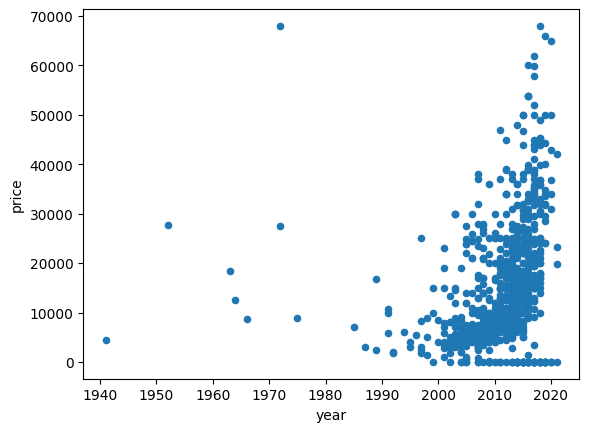

In [304]:
# plot price data on the chart to look for outliers

used_cars_data.plot(kind='scatter',x='year', y='price', style='o')

used_cars_data.shape

(726, 17)

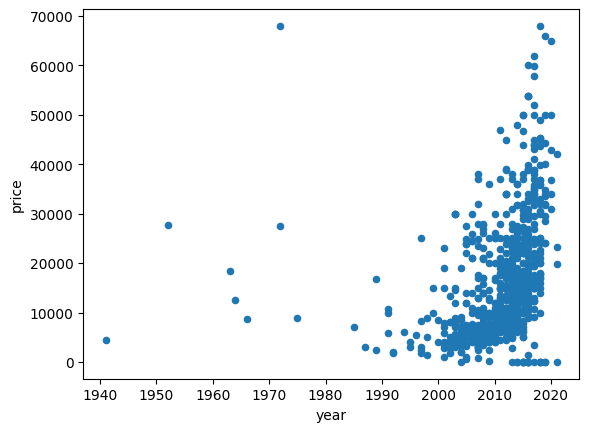

In [319]:
# lets remove data with price of the car = $0 or greater than $600,000 (this data point may change based on business feedback)

used_cars_data_clean = used_cars_data[used_cars_data['price'].gt(0) & used_cars_data['price'].lt(500000)].reset_index()

used_cars_data_clean.plot(kind='scatter',x='year', y='price', style='o')
used_cars_data_clean.shape

In [320]:
used_cars_data_clean.head(10)

# based on multicollinearity, lets drop thebelow features as they seems not having an impact on the price of the car
used_cars_data_clean = used_cars_data_clean.drop(['region','manufacturer', 'model'], axis=1).reset_index()


# Check for missing values
missing_values = used_cars_data_clean.isnull().sum()

print(missing_values)

level_0         0
index           0
price           0
year            0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64


In [321]:
# Encoding Categorical Variables
used_cars_data_encoded = pd.get_dummies(used_cars_data_clean, drop_first=True)
used_cars_data_encoded

,level_0,index,price,year,odometer,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,...,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv
0,0,67433,7000,2008.0,153500.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,308709,26900,2015.0,170713.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,155867,9995,2012.0,86800.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,191488,43900,2017.0,24005.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,307150,7000,2009.0,133000.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,721,98821,31795,2017.0,115541.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
722,722,104051,8995,2014.0,99661.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
723,723,282853,29800,2016.0,97601.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
724,724,13573,5500,1996.0,218361.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [322]:
# VIF - measure of the multicollinearity in the independent features

def vif(exogs, data):
  vif_dict = {}

  for exog in exogs:
    not_exog = [i for i in exogs if i != exog]
    X11, y11 = data[not_exog], data[exog]

    r_squared = LinearRegression().fit(X11,y11).score(X11,y11)

    # calc the VIF
    if(r_squared !=0):
        vif = 1/(1-r_squared)
    else:
        vif = 1
    vif_dict[exog] = vif
    
    print(pd.DataFrame({"VIF":vif_dict}))

  return pd.DataFrame({"VIF":vif_dict})

In [323]:
# Find Collinearity between features
X1 = used_cars_data_encoded.drop('price', axis=1)
y1 = used_cars_data_encoded['price']
X1_train ,X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
vif(X1.columns, X1).sort_values(by = 'VIF', ascending = False)

              VIF
level_0  1.143627
                VIF
index    408.816690
level_0    1.143627
                VIF
index    408.816690
level_0    1.143627
year       2.301994
                 VIF
index     408.816690
level_0     1.143627
odometer    1.697951
year        2.301994
                       VIF
condition_fair    1.255117
index           408.816690
level_0           1.143627
odometer          1.697951
year              2.301994
                       VIF
condition_fair    1.255117
condition_good    1.469271
index           408.816690
level_0           1.143627
odometer          1.697951
year              2.301994
                           VIF
condition_fair        1.255117
condition_good        1.469271
condition_like new    1.307123
index               408.816690
level_0               1.143627
odometer              1.697951
year                  2.301994
                           VIF
condition_fair        1.255117
condition_good        1.469271
condition_like new    1.307

,VIF
index,408.816690
state_wi,177.472467
state_tx,165.965335
state_ny,120.969279
state_pa,118.405191
...,...
type_offroad,1.142111
title_status_rebuilt,1.131589
paint_color_yellow,1.123185
title_status_lien,1.111154


In [325]:
# Feature Scaling:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(used_cars_data_encoded.drop('price', axis=1))
#used_cars_scaled = pd.DataFrame(scaled_features, columns=used_cars_data_encoded.columns.drop('price'))
#used_cars_scaled['price'] = used_cars_data['price']
#used_cars_scaled.dropna()
used_cars_scaled = pd.DataFrame(scaled_features, columns=used_cars_data_encoded.columns.drop('price'))
used_cars_scaled.tail()
print(used_cars_scaled.shape)
print(used_cars_data_encoded.shape)


(726, 101)
(726, 102)


In [327]:
# Introspect the data and add the price feature back to the dataframe
used_cars_data_encoded['price']
used_cars_scaled['price'] = used_cars_data_encoded['price']
used_cars_scaled

,level_0,index,year,odometer,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,cylinders_3 cylinders,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,price
0,-1.729667,-1.189230,-0.378057,0.707135,-0.091287,-0.648648,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,7000
1,-1.724895,0.814867,0.551898,0.975222,-0.091287,-0.648648,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,26900
2,-1.720124,-0.454676,0.153346,-0.331695,-0.091287,1.541669,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,9995
3,-1.715352,-0.158799,0.817599,-1.309706,-0.091287,-0.648648,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,43900
4,-1.710581,0.801917,-0.245207,0.387854,-0.091287,1.541669,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,1.710581,-0.928514,0.817599,0.115936,-0.091287,-0.648648,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,31795
722,1.715352,-0.885072,0.419047,-0.131389,-0.091287,-0.648648,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,8995
723,1.720124,0.600100,0.684749,-0.163473,-0.091287,-0.648648,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,29800
724,1.724895,-1.636604,-1.972266,1.717323,-0.091287,1.541669,-0.36172,-0.052559,-0.052559,-0.052559,...,-0.037139,-0.154846,-0.214731,-0.091287,-0.150117,-0.163933,-0.11818,-0.196537,-0.037139,5500


In [329]:
# ensure price is added back and there is no missing values before we start modelling 
missing_values_scaled = used_cars_scaled.isnull().sum()
print(missing_values_scaled)

level_0           0
index             0
year              0
odometer          0
condition_fair    0
                 ..
state_vt          0
state_wa          0
state_wi          0
state_wv          0
price             0
Length: 102, dtype: int64


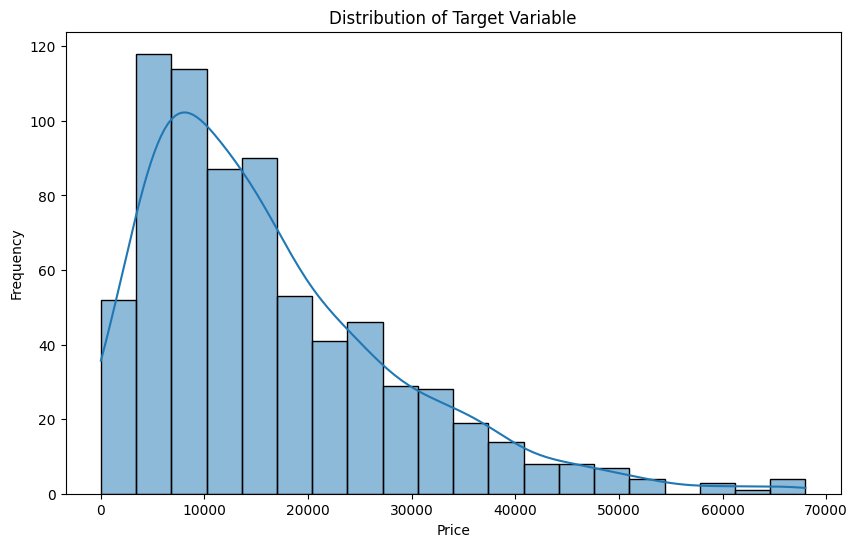

In [330]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(used_cars_scaled['price'], kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

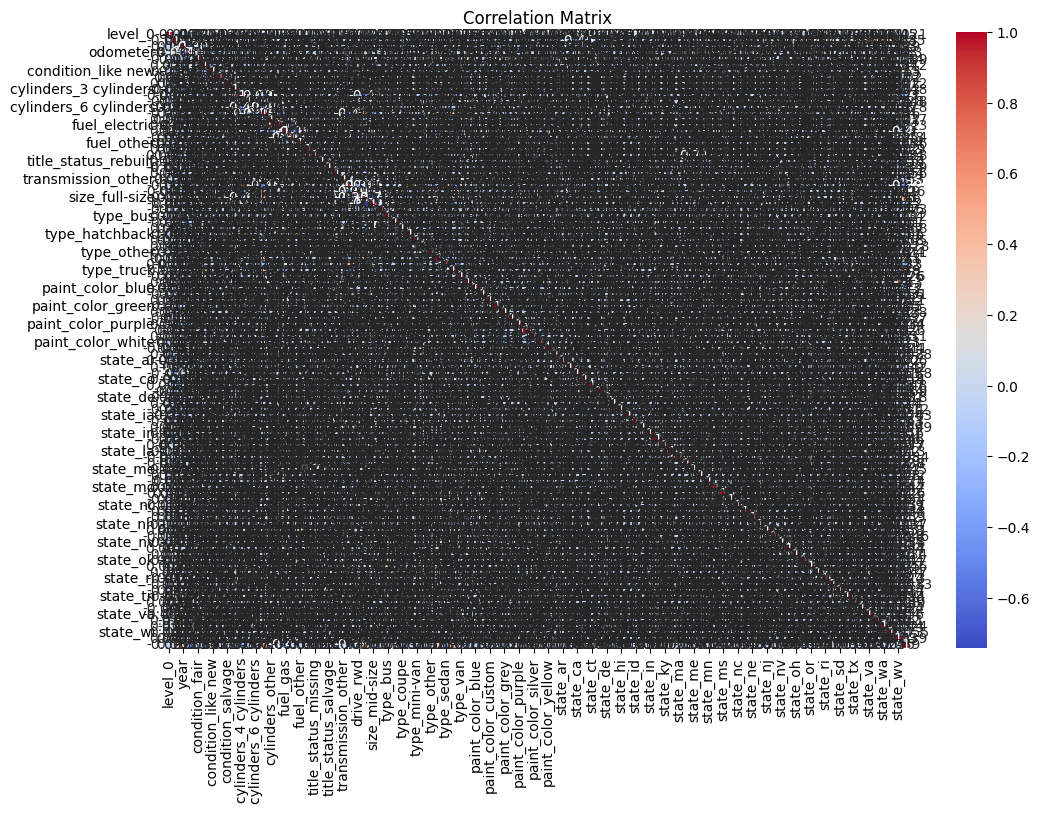

In [331]:

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(used_cars_scaled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Handle missing values (example: filling with mean)
#used_cars.fillna(used_cars.mean(), inplace=True)

In [332]:
print (used_cars_scaled.columns)

Index(['level_0', 'index', 'year', 'odometer', 'condition_fair',
       'condition_good', 'condition_like new', 'condition_new',
       'condition_salvage', 'cylinders_3 cylinders',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt',
       'state_wa', 'state_wi', 'state_wv', 'price'],
      dtype='object', length=102)


# Splitting the data

In [334]:
X = used_cars_scaled.drop('price', axis=1)
y = used_cars_scaled['price']
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and Evaluating the Model

### Linear Regression 

In [336]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_liner = r2_score(y_test, y_pred_linear)
print ('MSE : ' + str(mse_linear))
print ('R2 : ' + str(r2_liner))

MSE : 6.47039236825145e+30
R2 : -4.184832825318296e+22


### Ridge Regression

In [337]:
ridge_model = Ridge(alpha=1.0)  # You can tune the alpha parameter
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print ('MSE Ridge: ' + str(mse_ridge))
print ('R2 Ridge: ' + str(r2_ridge))

MSE Ridge: 64255801.66664236
R2 Ridge: 0.5844150204072183


### Lasso Regression 

In [339]:
lasso_model = Lasso(alpha=1.0)  # You can tune the alpha parameter
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print ('MSE Lasso: ' + str(mse_lasso))
print ('R2 Lasso: ' + str(r2_lasso))

MSE Lasso: 64333741.913167246
R2 Lasso: 0.5839109290268081


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.804e+07, tolerance: 8.844e+06
  model = cd_fast.enet_coordinate_descent(


# Applying Cross-Validation and Hyperparameter Tuning

In [340]:
# Linear Regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


In [341]:
# Linear Regression with Cross-Validation
linear_model = LinearRegression()
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print("Linear Regression Cross-Validation MAE Scores:", -linear_cv_scores)
print("Linear Regression Cross-Validation Mean MAE:", -np.mean(linear_cv_scores))


Linear Regression Cross-Validation MAE Scores: [1.76453908e+15 7.94996782e+15 9.98232998e+14 1.29511310e+16
 5.36340288e+15]
Linear Regression Cross-Validation Mean MAE: 5805454753659155.0


In [342]:
# Lasso Regression

In [343]:
# Lasso Regression with GridSearchCV
lasso_model = Lasso()
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='neg_mean_absolute_error')
lasso_grid.fit(X_train, y_train)

print("Best Lasso Alpha:", lasso_grid.best_params_['alpha'])
print("Best Lasso CV Score:", -lasso_grid.best_score_)


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+10, tolerance: 6.584e+06
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+10, tolerance: 7.736e+06
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+10, tolerance: 6.596e+06

Best Lasso Alpha: 100
Best Lasso CV Score: 6477.729772783869


In [158]:
# Ridge Regression

In [159]:
# Ridge Regression with GridSearchCV
ridge_model = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_mean_absolute_error')
ridge_grid.fit(X_train, y_train)

print("Best Ridge Alpha:", ridge_grid.best_params_['alpha'])
print("Best Ridge CV Score:", -ridge_grid.best_score_)


Best Ridge Alpha: 100
Best Ridge CV Score: 10837.65286618088


In [160]:
# Evaluating the Tuned Models on Test Data
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [163]:
# Train the models with the best hyperparameters
best_lasso = Lasso(alpha=lasso_grid.best_params_['alpha'])
best_ridge = Ridge(alpha=ridge_grid.best_params_['alpha'])

best_lasso.fit(X_train, y_train)
best_ridge.fit(X_train, y_train)

# Make predictions
linear_pred_eval = linear_model.fit(X_train, y_train).predict(X_test)
lasso_pred_eval = best_lasso.predict(X_test)
ridge_pred_eval = best_ridge.predict(X_test)

# Evaluate the models
linear_mae_eval = mean_absolute_error(y_test, linear_pred_eval)
linear_mse_eval = mean_squared_error(y_test, linear_pred_eval)
linear_r_squared_eval = linear_model.score(X_test, y_test)

lasso_mae_eval = mean_absolute_error(y_test, lasso_pred_eval)
lasso_mse_eval = mean_squared_error(y_test, lasso_pred_eval)
lasso_r_squared_eval = best_lasso.score(X_test, y_test)

ridge_mae_eval = mean_absolute_error(y_test, ridge_pred_eval)
ridge_mse_eval = mean_squared_error(y_test, ridge_pred_eval)
ridge_r_squared_eval = best_ridge.score(X_test, y_test)

print(f'Linear Regression MAE: {linear_mae_eval}')
print(f'Linear Regression MSE: {linear_mse_eval}')
print(f'Linear Regression R-squared: {linear_r_squared_eval}\n')

print(f'Lasso Regression MAE: {lasso_mae_eval}')
print(f'Lasso Regression MSE: {lasso_mse_eval}')
print(f'Lasso Regression R-squared: {lasso_r_squared_eval}\n')

print(f'Ridge Regression MAE: {ridge_mae_eval}')
print(f'Ridge Regression MSE: {ridge_mse_eval}')
print(f'Ridge Regression R-squared: {ridge_r_squared_eval}\n')


Linear Regression MAE: 1.9103335940649295e+18
Linear Regression MSE: 1.3554588713763465e+37
Linear Regression R-squared: -1.194131503182264e+29

Lasso Regression MAE: 11573.149097696267
Lasso Regression MSE: 212583322.9202657
Lasso Regression R-squared: -0.8728155336243675

Ridge Regression MAE: 10146.8772036485
Ridge Regression MSE: 155066929.8861728
Ridge Regression R-squared: -0.3661078914981055

